In [ ]:
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
import cv2
import tqdm as tqdm
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
from tqdm import tqdm
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)
set_session(sess)

%matplotlib inline

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/paper/ocular.zip' -d '/content/drive/MyDrive/paper/'

Archive:  /content/drive/MyDrive/paper/ocular.zip
replace /content/drive/MyDrive/paper/dataset/cataract/0_left.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/MyDrive/paper/dataset/cataract/0_left.jpg  
  inflating: /content/drive/MyDrive/paper/dataset/cataract/103_left.jpg  
  inflating: /content/drive/MyDrive/paper/dataset/cataract/1062_right.jpg  
  inflating: /content/drive/MyDrive/paper/dataset/cataract/1083_left.jpg  
  inflating: /content/drive/MyDrive/paper/dataset/cataract/1084_right.jpg  
  inflating: /content/drive/MyDrive/paper/dataset/cataract/1102_left.jpg  
  inflating: /content/drive/MyDrive/paper/dataset/cataract/1102_right.jpg  
  inflating: /content/drive/MyDrive/paper/dataset/cataract/1115_left.jpg  
  inflating: /content/drive/MyDrive/paper/dataset/cataract/1126_right.jpg  
  inflating: /content/drive/MyDrive/paper/dataset/cataract/112_right.jpg  
  inflating: /content/drive/MyDrive/paper/dataset/cataract/1144_left.jpg  
  inflating: /conte

In [ ]:
root_dir = "/content/drive/MyDrive/paper/dataset"
os.listdir(root_dir)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [ ]:
normal = "/content/drive/MyDrive/paper/dataset/normal"
glaucoma = "/content/drive/MyDrive/paper/dataset/glaucoma"
diabetic_retinopathy = "/content/drive/MyDrive/paper/dataset/diabetic_retinopathy"
cataract = "/content/drive/MyDrive/paper/dataset/cataract"

In [ ]:
print(f"normal: {len(os.listdir(normal))}")
print(f"glaucoma: {len(os.listdir(glaucoma))}")
print(f"diabetic_retinopathy: {len(os.listdir(diabetic_retinopathy))}")
print(f"cataract: {len(os.listdir(cataract))}")

normal: 1074
glaucoma: 1007
diabetic_retinopathy: 1098
cataract: 1038


In [ ]:
x = []
y = [] 
dataset =[]
def create_dataset(directory,dir_name):
    for i in tqdm(os.listdir(directory)):
        full_path = os.path.join(directory,i)
        try:
            img = cv2.imread(full_path)
            img = cv2.resize(img,(150,150))
        except:
            continue
        x.append(img)
        y.append(dir_name)
    return x,y

In [ ]:
x,y= create_dataset(normal,"normal")
x,y= create_dataset(glaucoma,"glaucoma")
x,y= create_dataset(diabetic_retinopathy,"diabetic_retinopathy")
x,y= create_dataset(cataract,"cataract")

100%|██████████| 1038/1038 [00:27<00:00, 37.61it/s]


In [ ]:
x =  np.array(x)
y = np.array(y)
x.shape,y.shape

((4217, 150, 150, 3), (4217,))

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
img_size =150

x_train = np.array(x_train)/255.0
x_test = np.array(x_test)/255.0


x_train = x_train.reshape(-1,img_size,img_size,3)
y_train = np.array(y_train)

x_test = x_test.reshape(-1,img_size,img_size,3)
y_test = np.array(y_test)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train_lb = lb.fit_transform(y_train)
y_test_lb = lb.fit_transform(y_test)

In [ ]:
y_train_lb.shape,y_test_lb.shape

((3373, 4), (844, 4))

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights = "imagenet",include_top=False,input_shape=(img_size,img_size,3))

80134624/80134624 [==============================] - 3s 0us/step


In [ ]:
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model =Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(4,activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 4)                 32772     
                                                                 
Total params: 20,057,156
Trainable params: 32,772
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics="accuracy")

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False)
earlystop = EarlyStopping(monitor="val_accuracy",patience=4,verbose=1)

In [ ]:
unique,counts = np.unique(y_train_lb,return_counts=True)
print(unique,counts)

[0 1] [10119  3373]


In [ ]:
history =  model.fit(x_train,y_train_lb,epochs=10,validation_data=(x_test,y_test_lb),
                     batch_size=64 ,verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/10
53/53 [==============================] - ETA: 0s - loss: 0.8296 - accuracy: 0.6540
Epoch 1: val_accuracy improved from -inf to 0.74763, saving model to vgg19.h5
53/53 [==============================] - 26s 310ms/step - loss: 0.8296 - accuracy: 0.6540 - val_loss: 0.6022 - val_accuracy: 0.7476
Epoch 2/10
53/53 [==============================] - ETA: 0s - loss: 0.5239 - accuracy: 0.8040
Epoch 2: val_accuracy improved from 0.74763 to 0.82938, saving model to vgg19.h5
53/53 [==============================] - 13s 244ms/step - loss: 0.5239 - accuracy: 0.8040 - val_loss: 0.4857 - val_accuracy: 0.8294
Epoch 3/10
53/53 [==============================] - ETA: 0s - loss: 0.4626 - accuracy: 0.8283
Epoch 3: val_accuracy improved from 0.82938 to 0.84360, saving model to vgg19.h5
53/53 [==============================] - 13s 252ms/step - loss: 0.4626 - accuracy: 0.8283 - val_loss: 0.4389 - val_accuracy: 0.8436
Epoch 4/10
53/53 [==============================] - ETA: 0s - loss: 0.4267 - accur

In [ ]:
loss,accuracy = model.evaluate(x_test,y_test_lb)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}") 

27/27 [==============================] - 4s 95ms/step - loss: 0.3420 - accuracy: 0.8744
Loss: 0.34198305010795593
Accuracy: 0.8744075894355774


In [ ]:
y_pred=model.predict(x_test) 
classes_x=np.argmax(y_pred,axis=1)


27/27 [==============================] - 3s 94ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,classes_x))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       196
           1       1.00      0.98      0.99       205
           2       0.82      0.74      0.78       198
           3       0.86      0.85      0.86       245

    accuracy                           0.87       844
   macro avg       0.87      0.87      0.87       844
weighted avg       0.88      0.87      0.87       844



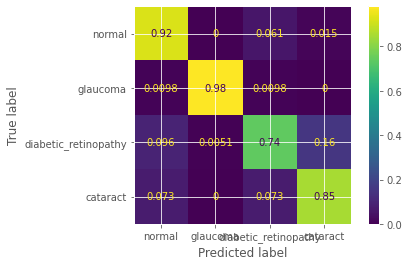

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test, classes_x, normalize='true')
cmd = ConfusionMatrixDisplay(cm, display_labels=["normal", "glaucoma", "diabetic_retinopathy", "cataract"])
cmd.plot()


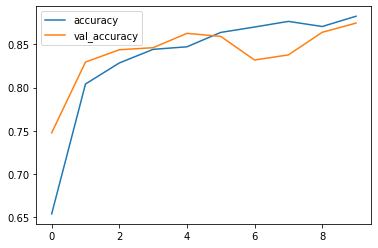

In [ ]:
metrics = pd.DataFrame(history.history)
metrics[['accuracy','val_accuracy']].plot()

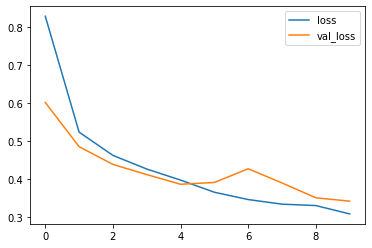

In [ ]:
metrics[['loss','val_loss']].plot()

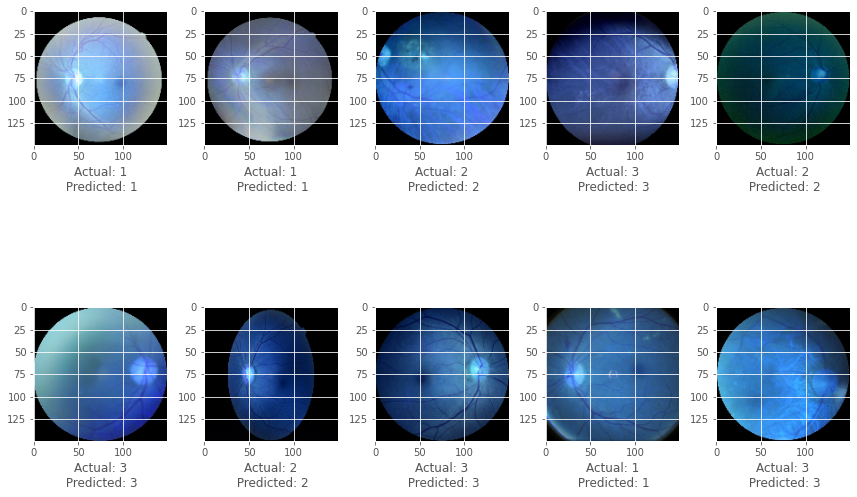

In [ ]:
plt.figure(figsize=(12,9))
plt.style.use("ggplot")
for i in range(10):
    sample = random.choice(range(len(x_test)))
    plt.subplot(2,5,i+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(x_test[sample])
    plt.xlabel(f"Actual: {y_test[sample]}\n Predicted: {classes_x[sample]}")
    
plt.tight_layout()    
plt.show()  